# Benchmarks comparing push and pull strategies for interface between CCX Data Pipeline and ACM

## User story
- As an SRE, I want the analytics to provide me a multi-cluster view vs individual cluster view. I expect the results for multi clusters to be retrieved as fast as possible not to lose any recent problems.

## About the task
- The task is to compare (by using benchmarks) if the push strategy is more appropriate than push strategy for implementing interface between CCX Data Pipeline and ACM

## Acceptance criteria
- PoC for interface to ACM that use **pull** strategy
- PoC for interface to ACM that use **push** strategy
- Benchmarks for both strategies
- Demo presented on CCX Demo meeting

## Architecture diagram of CCX Data Pipeline based on pull model (request-response)

![CCX Data Pipeline architecture](customer-facing-services-architecture.png)

### The classic pull model
- based on request-response apporach
- fully compatible with HTTP/HTTPS
- repeated operations for each cluster
![ACM interface pull model](acm_interface_pull_model.png)

### The push model (streaming)
- based on web sockets
- fully compatible with common network configurations
- no repeated operations
- recommendations are pushed as they are produced in CCX Data Pipeline
- based on timestamp of last result (might be changed to DB ID)
![ACM interface push model](acm_interface_push_model.png)

## Benchmarks
- pull model is easier to implement, but might be slower
- we need to measure the possible speedups by using push model (web sockets)

### Three scenarios
- local machine to local machine (w/o network lattency)
- local machine to remote machine (with network lattency)
- remote machine to remote machine (cross check for previous results)

## Machines used to run benchmarks

### Local machine
```

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               94
Model name:          Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
Stepping:            3
CPU MHz:             900.222
CPU max MHz:         3600.0000
CPU min MHz:         800.0000
BogoMIPS:            5424.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
NUMA node0 CPU(s):   0-7
```

### Remote machine
```
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       46 bits physical, 48 bits virtual
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  1
Core(s) per socket:  1
Socket(s):           2
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel Xeon Processor (Skylake, IBRS)
Stepping:            4
CPU MHz:             2095.082
BogoMIPS:            4190.16
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            4096K
NUMA node0 CPU(s):   0,1
```

### Benchmark initizalization part

In [55]:
# we are going to display graphs and work with data frames

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# let's display all graphs without the need to call .show()
%matplotlib inline

In [56]:
# read all results that were stored in CSV files

# pull model results
pull_model_local_local = pd.read_csv('pull_model_local_local.csv')
pull_model_local_remote = pd.read_csv('pull_model_local_remote.csv')
pull_model_remote_remote = pd.read_csv('pull_model_remote_remote.csv')

# push model results
push_model_local_local = pd.read_csv('push_model_local_local.csv')
push_model_local_remote = pd.read_csv('push_model_local_remote.csv')
push_model_remote_remote = pd.read_csv('push_model_remote_remote.csv')

In [57]:
# let's skim over the raw data

In [58]:
pull_model_local_local.head(10)

,#,usec,error
0,1,1559,0
1,2,639,0
2,3,619,0
3,4,599,0
4,5,666,0
5,6,605,0
6,7,519,0
7,8,466,0
8,9,328,0
9,10,401,0


In [59]:
pull_model_remote_remote.head(10)

,#,usec,error
0,1,2218,0
1,2,637,0
2,3,738,0
3,4,736,0
4,5,659,0
5,6,674,0
6,7,538,0
7,8,393,0
8,9,435,0
9,10,342,0


In [60]:
pull_model_local_remote.head(10)

,#,usec,error
0,1,618451,0
1,2,310522,0
2,3,305436,0
3,4,205066,0
4,5,204009,0
5,6,203394,0
6,7,205129,0
7,8,204122,0
8,9,204500,0
9,10,204514,0


In [61]:
pull_model_local_local.describe()

,#,usec,error
count,10000.00000,10000.000000,10000.0
mean,5000.50000,561.552000,0.0
std,2886.89568,202.359802,0.0
min,1.00000,181.000000,0.0
25%,2500.75000,393.000000,0.0
50%,5000.50000,573.000000,0.0
75%,7500.25000,672.000000,0.0
max,10000.00000,3878.000000,0.0


In [62]:
pull_model_remote_remote.describe()

,#,usec,error
count,10000.00000,10000.000000,10000.0
mean,5000.50000,510.027100,0.0
std,2886.89568,177.366068,0.0
min,1.00000,178.000000,0.0
25%,2500.75000,364.000000,0.0
50%,5000.50000,529.000000,0.0
75%,7500.25000,615.000000,0.0
max,10000.00000,3319.000000,0.0


In [63]:
pull_model_local_remote.describe()

,#,usec,error
count,10005.000000,1.000500e+04,10005.000000
mean,4999.682959,2.176198e+05,0.000500
std,2886.977330,7.006176e+04,0.022351
min,1.000000,0.000000e+00,0.000000
25%,2499.000000,2.034060e+05,0.000000
50%,4999.000000,2.046610e+05,0.000000
75%,7500.000000,2.070740e+05,0.000000
max,10000.000000,2.000857e+06,1.000000


## Comparison

### Local to local communication

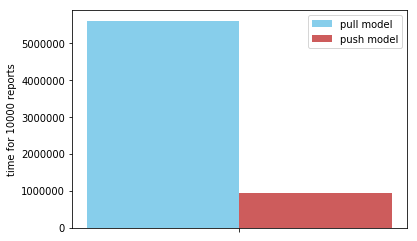

In [64]:
t_pull = sum(pull_model_local_local["usec"])
t_push = sum(push_model_local_local["usec"])

# x locations for the groups
ind = np.arange(1)

# width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, t_pull, width, color='SkyBlue', label='pull model')
rects2 = ax.bar(ind + width/2, t_push, width, color='IndianRed', label='push model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time for 10000 reports')
ax.set_xticks(ind)
ax.set_xticklabels('')
ax.legend()

### Remote to remote communication

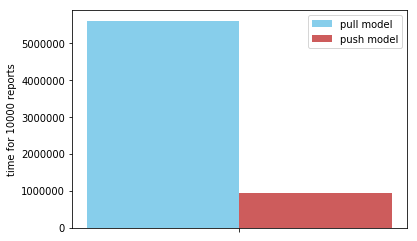

In [65]:
t_pull_model = sum(pull_model_remote_remote["usec"])
t_push_model = sum(push_model_remote_remote["usec"])

# x locations for the groups
ind = np.arange(1)

# width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, t_pull, width, color='SkyBlue', label='pull model')
rects2 = ax.bar(ind + width/2, t_push, width, color='IndianRed', label='push model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time for 10000 reports')
ax.set_xticks(ind)
ax.set_xticklabels('')
ax.legend()

### Local to remote communication

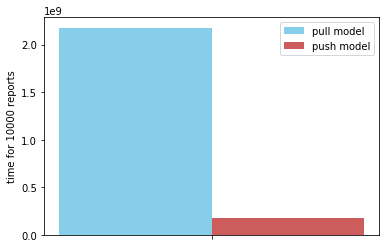

In [66]:
t_pull = sum(pull_model_local_remote["usec"])
t_push = sum(push_model_local_remote["usec"])

# x locations for the groups
ind = np.arange(1)

# width of the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, t_pull, width, color='SkyBlue', label='pull model')
rects2 = ax.bar(ind + width/2, t_push, width, color='IndianRed', label='push model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time for 10000 reports')
ax.set_xticks(ind)
ax.set_xticklabels('')
ax.legend()

## Conclusion

In [67]:
speedup = t_pull / t_push
print(speedup)

12.688230847392049


---
# Speedup >= 12!
---

### Behaviour in time

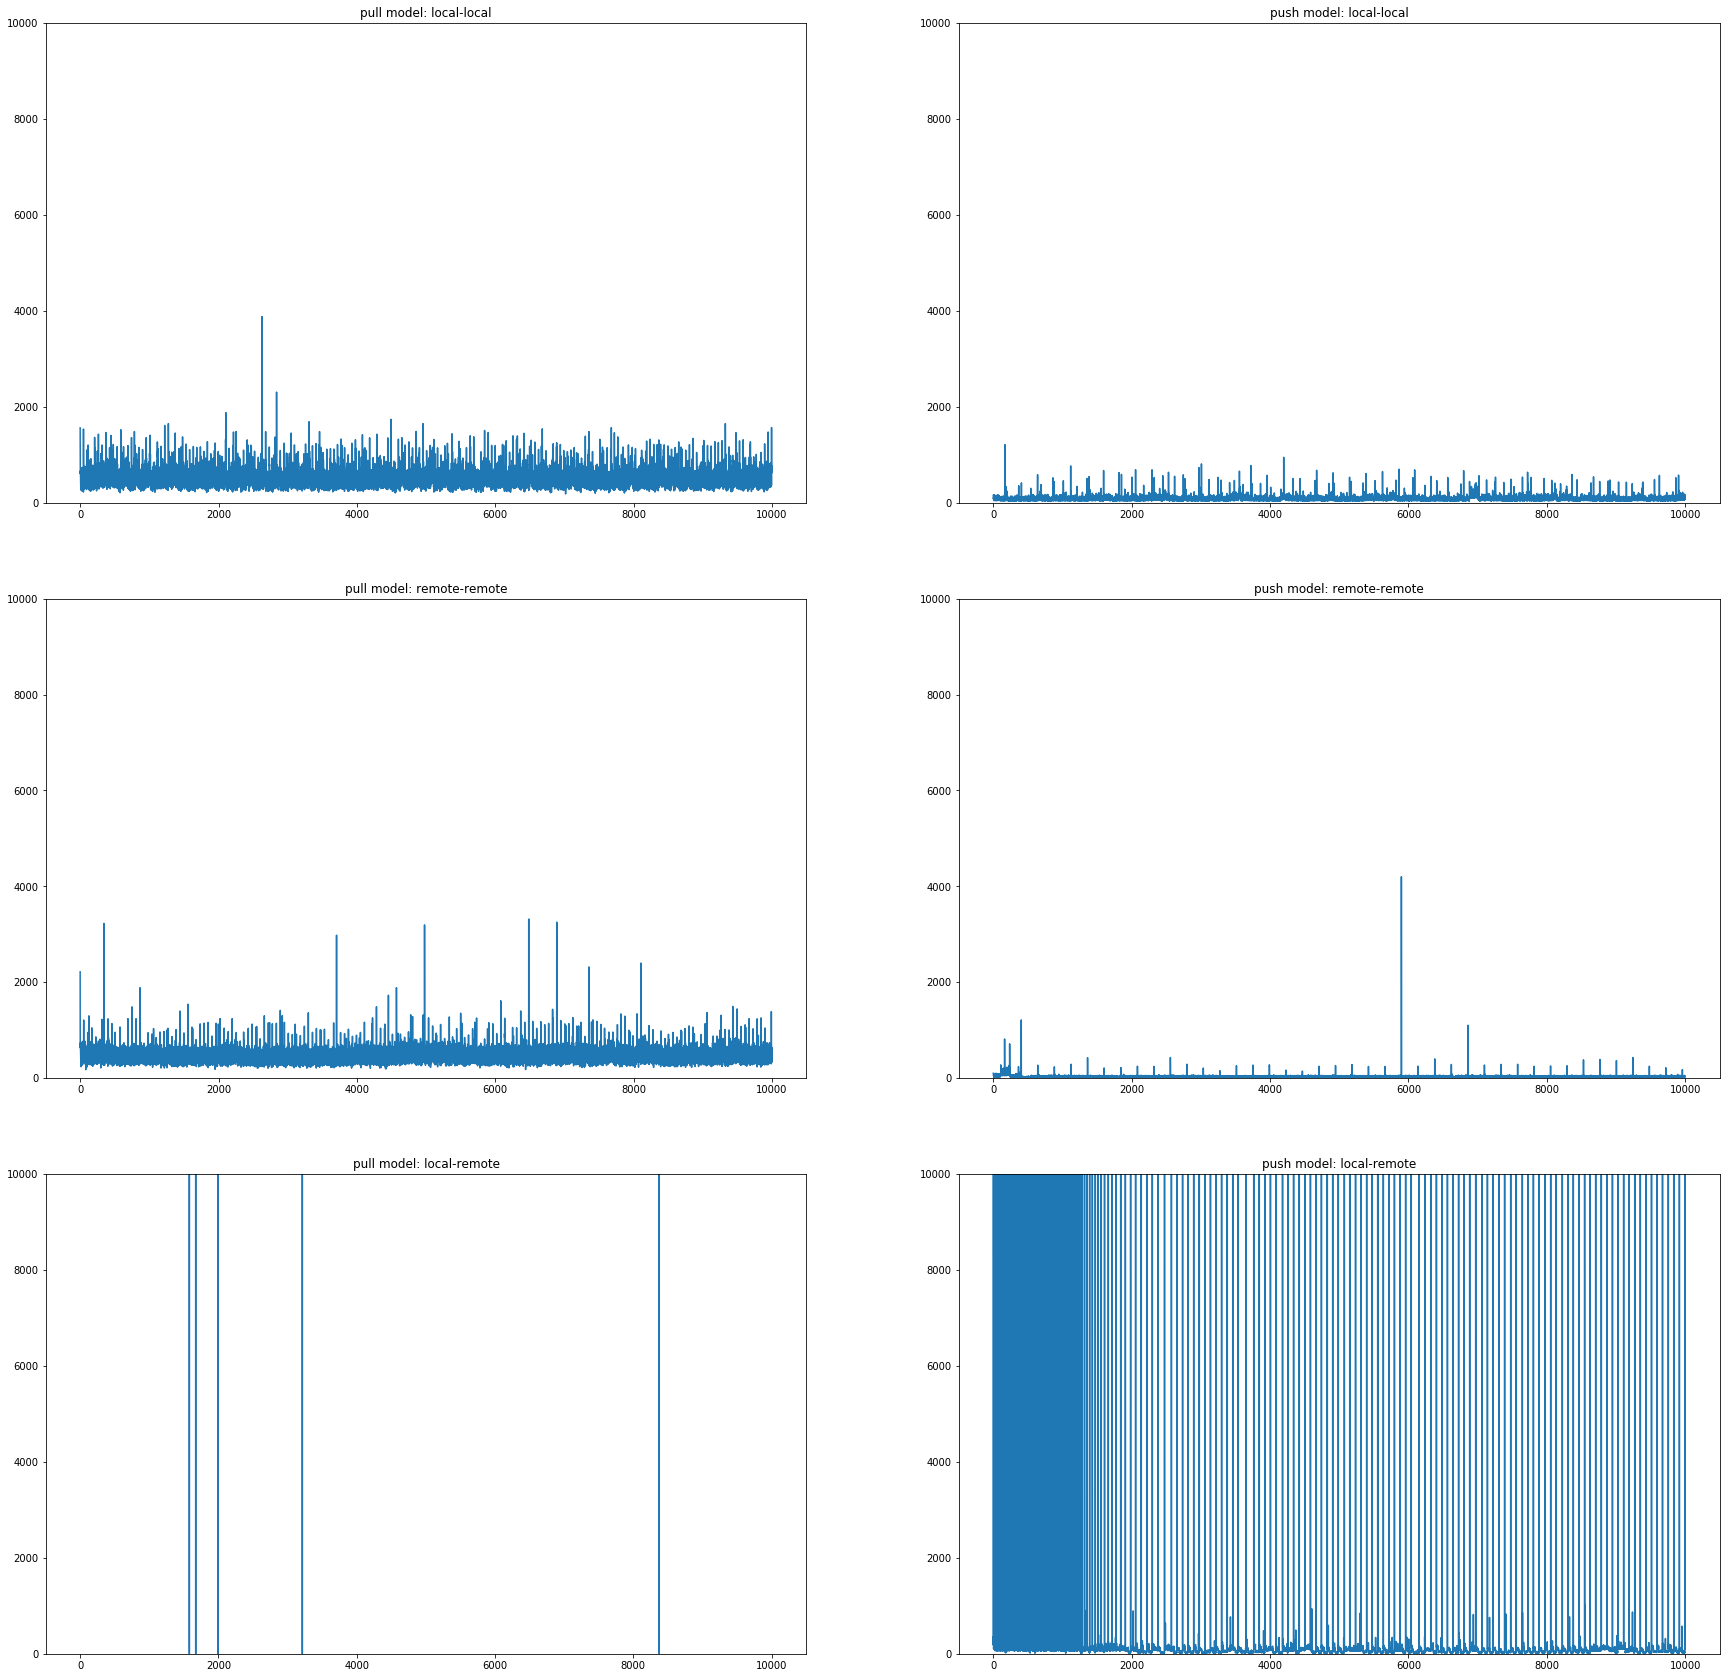

In [68]:
fig, axes = plt.subplots(3, 2, figsize=(30,30))
ylim = 10000

ax = axes[0][0]
ax.plot(pull_model_local_local["usec"])
ax.set_ylim((0,ylim))
ax.set_title("pull model: local-local")

ax = axes[1][0]
ax.plot(pull_model_remote_remote["usec"])
ax.set_ylim((0,ylim))
ax.set_title("pull model: remote-remote")

ax = axes[2][0]
ax.plot(pull_model_local_remote["usec"])
ax.set_ylim((0,ylim))
ax.set_title("pull model: local-remote")

ax = axes[0][1]
ax.plot(push_model_local_local["usec"])
ax.set_ylim((0,ylim))
ax.set_title("push model: local-local")

ax = axes[1][1]
ax.plot(push_model_remote_remote["usec"])
ax.set_ylim((0,ylim))
ax.set_title("push model: remote-remote")

ax = axes[2][1]
ax.plot(push_model_local_remote["usec"])
ax.set_ylim((0,ylim))
ax.set_title("push model: local-remote")

plt.show()

### Burst transfers in push model

#### Pull model has pretty "stable" timings

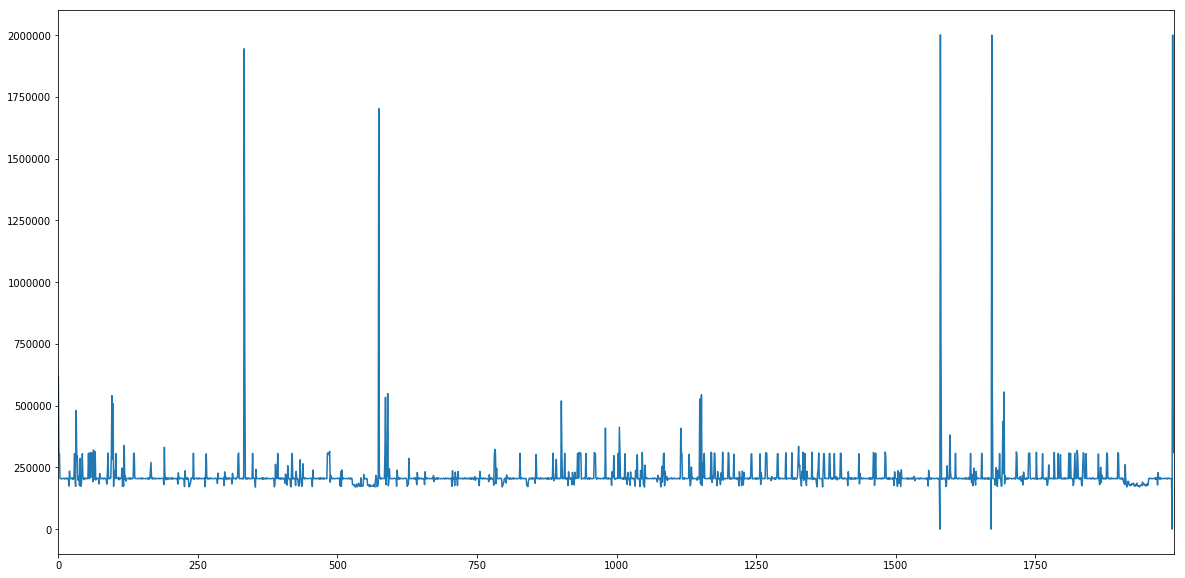

In [69]:
pull_model_local_remote["usec"][0:2000].plot(figsize=(20,10))

#### Push model has burst transfers

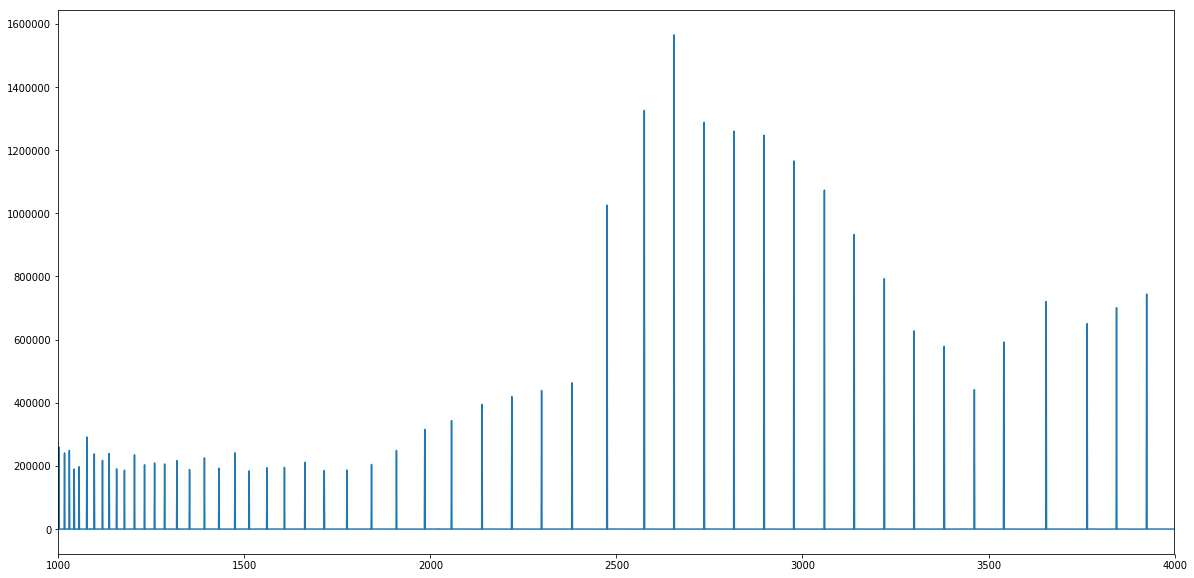

In [70]:
# would be nice to display some graphs as well, especially for overall duration
push_model_local_remote["usec"][1000:4000].plot(figsize=(20,10))

### Histograms are good everytime

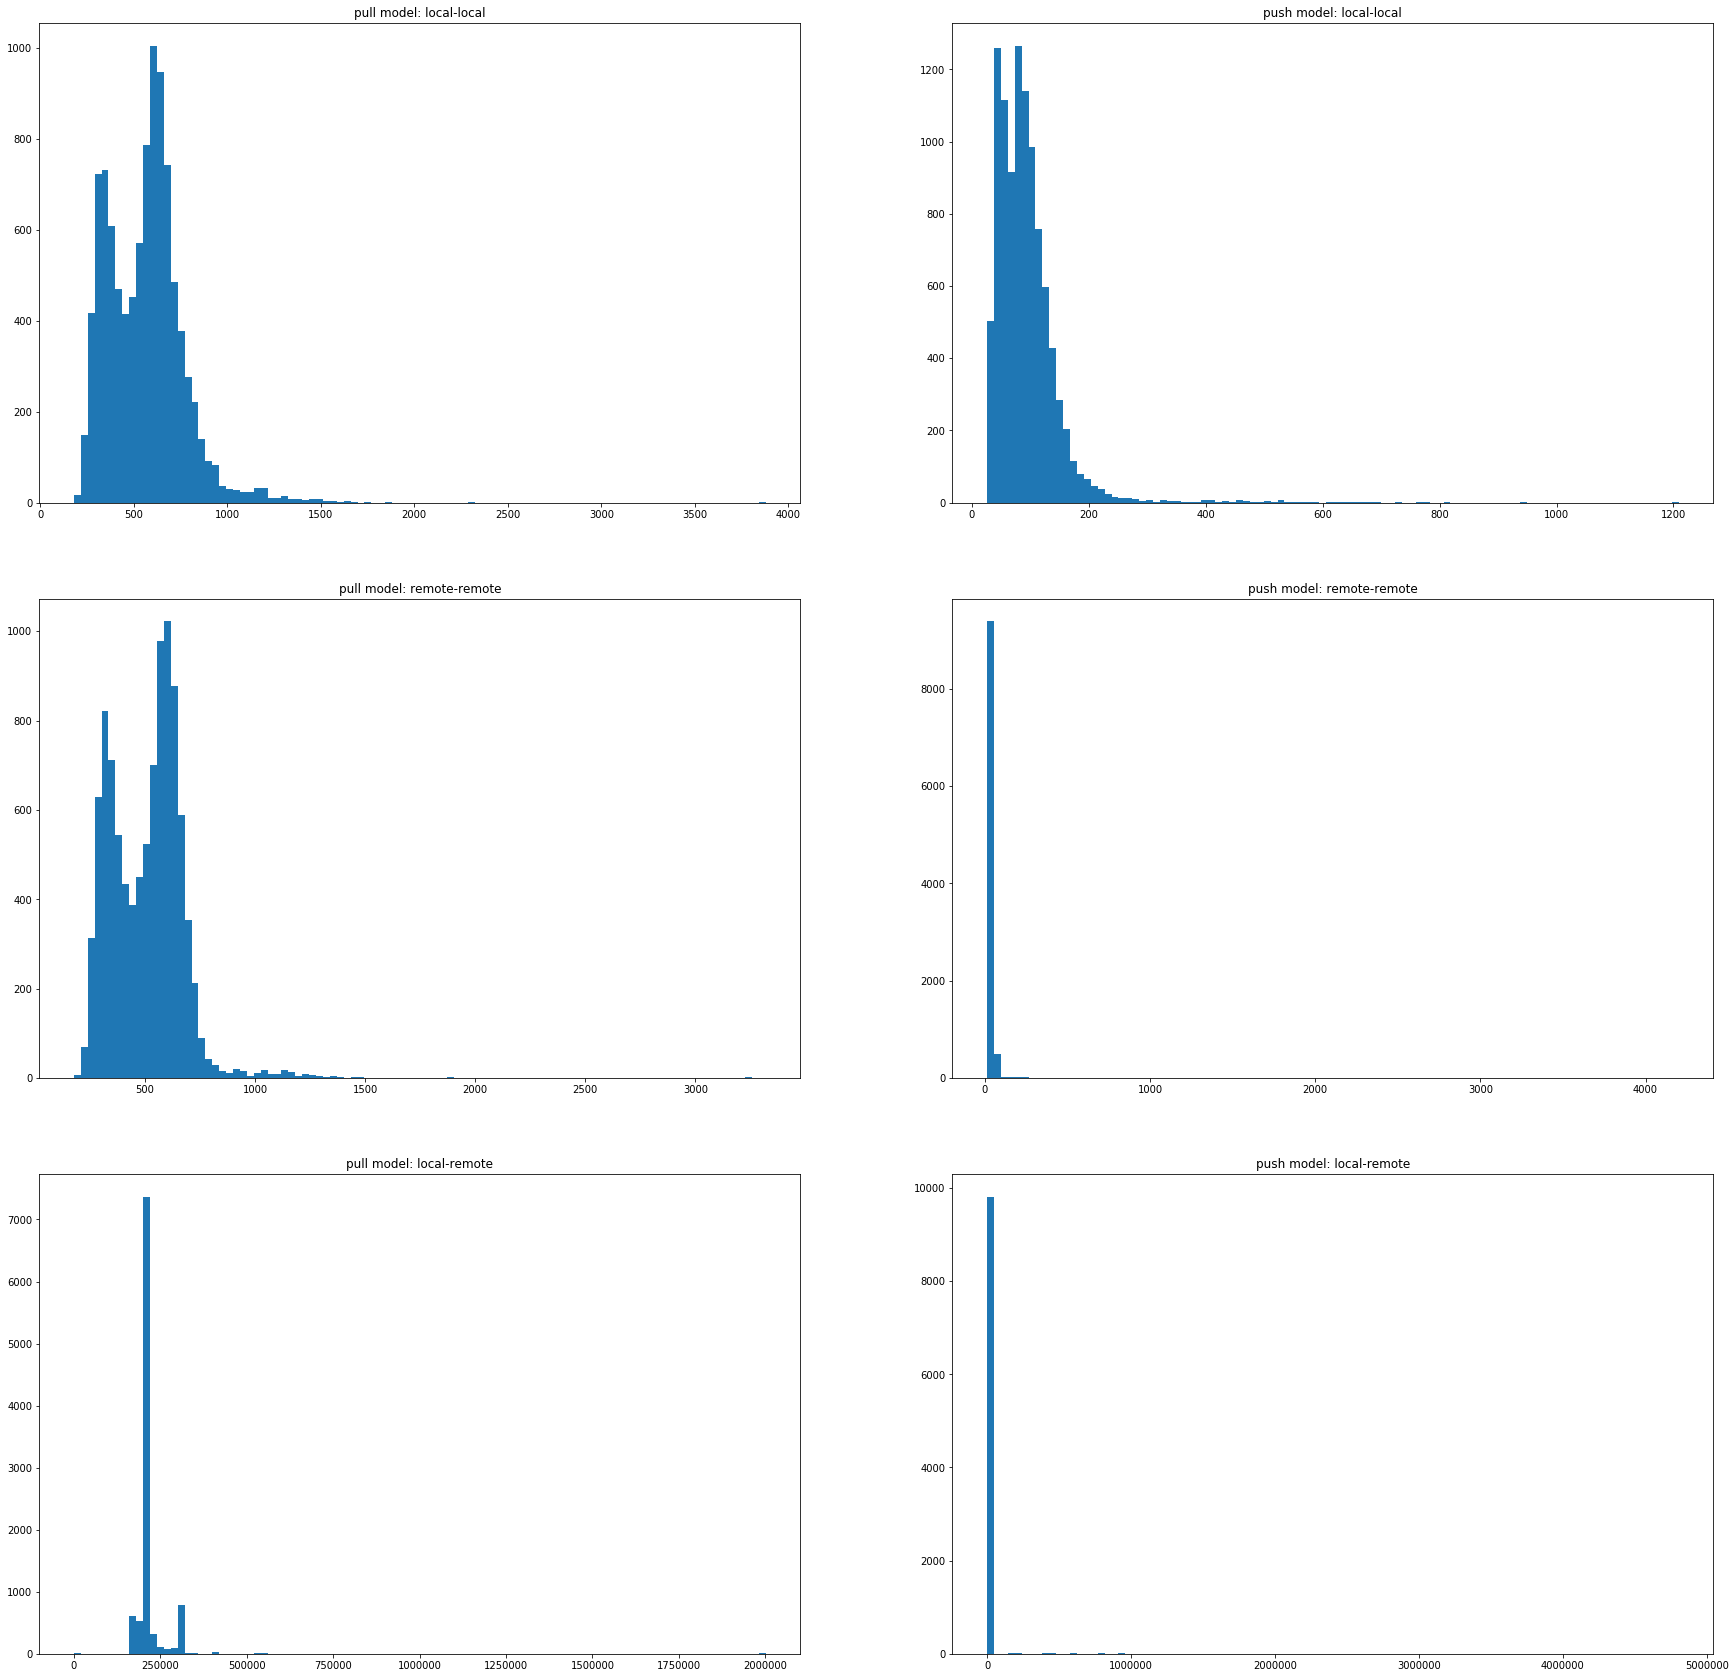

In [71]:
fig, axes = plt.subplots(3, 2, figsize=(30,30))
ylim = 10000

ax = axes[0][0]
ax.hist(pull_model_local_local["usec"], bins=100)
ax.set_title("pull model: local-local")

ax = axes[1][0]
ax.hist(pull_model_remote_remote["usec"], bins=100)
ax.set_title("pull model: remote-remote")

ax = axes[2][0]
ax.hist(pull_model_local_remote["usec"], bins=100)
ax.set_title("pull model: local-remote")

ax = axes[0][1]
ax.hist(push_model_local_local["usec"], bins=100)
ax.set_title("push model: local-local")

ax = axes[1][1]
ax.hist(push_model_remote_remote["usec"], bins=100)
ax.set_title("push model: remote-remote")

ax = axes[2][1]
ax.hist(push_model_local_remote["usec"], bins=100)
ax.set_title("push model: local-remote")

plt.show()

In [54]:
# finito